In [1]:
from cv2 import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# just  a function for printing images
def display_img(title, img):
    cv2.imshow(title, img)

#Only considering sharps for now
def getNextSharp(first_note):
    octave = first_note[2]
    if first_note[:2] == "A#":
        return ("C#" + octave)
    elif first_note[:2] == "C#":
        return ("D#" + octave)
    elif first_note[:2] == "D#":
        return ("F#" + octave)
    elif first_note[:2] == "F#":
        return ("G#" + octave)
    elif first_note[:2] == "G#":
        next_octave = int(octave) + 1
        return ("A#" + str(next_octave))
    

#Flats
def getNextFlat(first_note):
    if first_note == "B♭":
        return "D♭"
    elif first_note == "D♭":
        return "E♭"
    elif first_note == "E♭":
        return "G♭"
    elif first_note == "G♭":
        return "A♭"
    elif first_note == "A♭":
        return "B♭"
      
#White notes
def getNextNote(first_note):
    octave = first_note[1]
    if first_note[0] == "A":
        return ("B" + octave)
    elif first_note[0] == "B":
        return ("C" + octave)
    elif first_note[0] == "C":
        return ("D" + octave)
    elif first_note[0] == "D":
        return ("E" + octave)
    elif first_note[0] == "E":
        return ("F" + octave)
    elif first_note[0] == "F":
        return ("G" + octave)
    elif first_note[0] == "G":
        next_octave = int(octave) + 1
        return ("A" + str(next_octave))


## 1. Load image in

Always start at the first frame - before ANY keys are clicked. This is because if a note is coloured on the keys themselves, our thresholding set-up doesn't work.

**There is an issue when people have intros...**

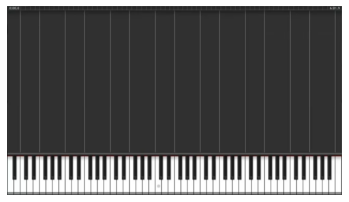

In [3]:
#sample piano image from youtube
img = cv2.imread("synthesia.png")

#converting to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

[174.0, 106.0]


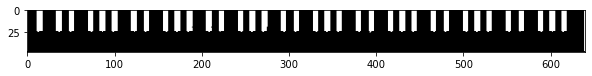

In [4]:
#Assume that the keys are definitely in the bottom half of the image
keys = img.copy()
keys = keys[keys.shape[0]//2:,:]

gray_keys = cv2.cvtColor(keys, cv2.COLOR_BGR2GRAY)

#edge detection 
std_dev = 0
k = 5
t1 = 200
t2 = 200

blurred = cv2.GaussianBlur(gray_keys, (k,k), std_dev)
edges = cv2.Canny(blurred, t1,t2, apertureSize = 3)

##########################################
### Using hough transform to identify lines 
lines = cv2.HoughLines(edges, 1, np.pi/180, 300)
#empty list - will be added with pixels that correspond with 
#the lines generated by hough transform 
y_cord = []


#iterating through lines
for line in lines: 
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    y_cord.append(y0) #appending to list
    x1 = int(x0 + 1500 * (-b))
    y1 = int(y0 + 1500 * (a))
    x2 = int(x0 - 1500 * (-b))
    y2 = int(y0 - 1500 * (a))
    cv2.line(keys, (x1,y1), (x2,y2), (0,255,0),2)
    #display_img("test", keys)
    #cv2.waitKey(0)

# ***We only want to crop by TWO coordinates - will need to figure this out 
# #sorting list and getting rid of smallest value
if (len(y_cord) > 2):
    y_cord.sort(reverse=True)
    y_cord.pop()

print(y_cord)
#cropping the image based on y_cord list
crop_img = keys[int(y_cord[1])+20:int(y_cord[0])]
crop_blur = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)

#Using standard threshold to create contrast between white/black keys
_, th1 = cv2.threshold(crop_blur, 85, 150, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(10,10))
plt.imshow(th1, cmap = "gray")
plt.show()

I count 36 black keys.


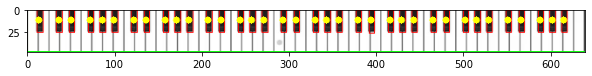

In [5]:
#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 1
output = cv2.connectedComponentsWithStats(th1, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]
# print(centroids.shape)

final_labels_bl = []

output = crop_img.copy()

#For loop only used for displaying 
for i in range(1, num_labels):
#     if i == 0:
#         text = "examining component {}/{} (background)".format(i + 1, num_labels)
#     else:
#         text = "examining component {}/{}".format(i+1, num_labels)

#     print("[INFO] {}".format(text))
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    if (100 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
        final_labels_bl.append(i)
        cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
        cv2.circle(output, (int(cX), int(cY)), 4, (255,255,0), -1)
        componentMask = (labels == i).astype("uint8") * 255
#         display_img("Output", output)
#         display_img("Connected Component", componentMask)
#         cv2.waitKey(0)

plt.figure(figsize=(10,10))
plt.imshow(output)
print("I count {} black keys.".format(len(final_labels_bl)))
    
cv2.destroyAllWindows()

## 1.1 Get the average width of a black key
This will be used to determine the discrete range of each key.

In [6]:
import statistics
bl_key_width = statistics.median(stats[:, cv2.CC_STAT_WIDTH])
print(bl_key_width)

6


# 2. Label Black Keys
We don't need to do distance math anymore. If we detect 36 black keys, we know that the first black key is A#.

In [ ]:
# #Printing out the difference between black keys
# #figure out someway to normalize this data so 
# #it works with all figures
# difference = []
# for i in range(len(final_labels)-1):
#     x2,y2 = centroids[final_labels[i+1]]
#     x1,y1 = centroids[final_labels[i]]
#     diff = x2-x1
#     difference.append(diff)
#     print(diff)

# #plotting distance between black keys vs centroids of all black keys
# x_axis = []
# for i in range(len(final_labels)-1):
#     x = centroids[final_labels[i]][0]
#     #print(x)
#     x_axis.append(x)

# plt.plot(x_axis, difference)
# plt.show()

In [ ]:
# #checking the difference for the next three notes to figure out
# #which note is being played
# ##########
# #! JUST A PROTOTYPE - NEEDS TO BE WOKED ON
# #right now it's hardcoded with numbers (40,20).. but needs to be normalized
# #########
# first_note = None
# if (difference[0] > 20):
#     if (difference[1] > 20):
#         pass
#     else:
#         if (difference[2] > 20):
#             first_note = 'A#'
#             print(first_note)

# black_key_dict = {}
# for i in range(len(final_labels)):
#     x = centroids[final_labels[i]][0]
#     black_key_dict[x] = first_note
#     first_note = getNextNote(first_note)

# print(black_key_dict)

*final_labels* is the 36 integer indices that tell us if the returned centroids are black keys. 

For example, if centroids returns 39 possible connected components, final_label is the list of 36 indices that we consider are black keys.

In [ ]:
# #Label indices starting from A#
# if len(final_labels_bl) == 36:
#     first_note = "A#"
#     black_key_dict = {}
#     for i in range(len(final_labels_bl)):
#         x = centroids[final_labels_bl[i]][0]
#         black_key_dict[x] = first_note
#         first_note = getNextSharp(first_note)
        
# tmp = img.copy()

# #Labeling all the black keys
# for centroid in black_key_dict:
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     y = tmp.shape[0]*3//4
#     lol = cv2.line(tmp,(int(centroid),0),(int(centroid),900),(0,0,255),1)
#     lol = cv2.putText(tmp, black_key_dict[centroid], (int(centroid), y), font, 0.5, (0,255,0), 1)
#     cv2.imshow("Label Sharps", tmp)
#     cv2.waitKey(0)
    
# cv2.destroyAllWindows()

In [7]:
#TESTING LIST
if len(final_labels_bl) == 36:
    first_note = "A#0"
    black_key_list = []
    for i in range(len(final_labels_bl)):
        x = centroids[final_labels_bl[i]][0]
        black_key_list.append([x,first_note])
        first_note = getNextSharp(first_note)
        
sorted(black_key_list, key=lambda x: x[0])
tmp = img.copy()

#Labeling all the black keys
for (centroid, note) in black_key_list:
    font = cv2.FONT_HERSHEY_SIMPLEX
    y = tmp.shape[0]*3//4
    lol = cv2.line(tmp,(int(centroid),0),(int(centroid),900),(0,0,255),1)
    lol = cv2.putText(tmp, note, (int(centroid), y), font, 0.5, (0,255,0), 1)
#     cv2.imshow("Label Sharps", tmp)
#     cv2.waitKey(0)
    
cv2.destroyAllWindows()

# 2. Label White Keys
Testing white keys

In [ ]:
# ##white key labelling
# #! NEED TO IMPLEMENT SPECIAL CONDITION FOR LAST WHITE KEYS 
# white_key_dict = {}
# for i in range(len(final_labels)-1):
#     x = centroids[final_labels[i]][0]

#     if (difference[i] > 40):
#         origin = x + difference[i]/2
#         delta_x = difference[i]/4
#         lol = cv2.line(img,(int(origin+delta_x),0), (int(origin+delta_x),900), (0,255,0),1)
#         lol = cv2.line(img,(int(origin-delta_x),0), (int(origin-delta_x),900), (0,255,0),1)
#         cv2.imshow("lol", lol)
#         cv2.waitKey(0)
#     else:
#         delta_x = difference[i]/2
#         lol = cv2.line(img,(int(x+delta_x),0), (int(x+delta_x),900), (0,255,0),1)
#         cv2.imshow("lol", lol)
#         cv2.waitKey(0)
        
# cv2.destroyAllWindows()

In [ ]:
# #Using standard threshold to create contrast between white/black keys
# kernel = np.ones((24,1), np.uint8)
# _, th2 = cv2.threshold(crop_blur, 1, 5, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# d_im = cv2.dilate(th2, kernel, iterations=4)
# e_im = cv2.erode(d_im, kernel, iterations=4)

(53, 2)
I count 52 white keys.


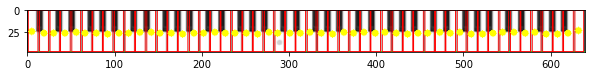

In [8]:
#Find optimal threshold - from testing we realized that the returned threshold is too low
import mahotas
k = 7
blurred = cv2.GaussianBlur(crop_blur, (k,k), 0)
T = mahotas.thresholding.otsu(blurred)*1.3
#print(T)

#We found the optimal threshold, now use it on our image
th2 = crop_blur.copy()  #Copy grayscale image and modify the copy
th2[th2>T] = 255     #Use Otsu's Threshold
th2[th2<T] = 0
# th2 = cv2.bitwise_not(th2) #Flips black-white



#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 8
output = cv2.connectedComponentsWithStats(th2, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]
print(centroids.shape)

final_labels_w = []

output = crop_img.copy()

#For loop only used for displaying 
for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    
    if (100 < area < np.inf): #filtering out relavent detections (the ones big enough to be white keys)
        final_labels_w.append(i)
        cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
        cv2.circle(output, (int(cX), int(cY)), 4, (255,255,0), -1)
        componentMask = (labels == i).astype("uint8") * 255
#         display_img("Output", output)
#         display_img("Connected Component", componentMask)
#         cv2.waitKey(0)
        
# cv2.destroyAllWindows()
print("I count {} white keys.".format(len(final_labels_w)))

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.show()

In [ ]:
# #Label indices starting from A#
# if len(final_labels_w) == 52:
#     first_note = "A"
#     white_key_dict = {}
#     for i in range(len(final_labels_w)):
#         x = centroids[final_labels_w[i]][0]
#         white_key_dict[x] = first_note
#         first_note = getNextNote(first_note)
        
# tmp = img.copy()

# #Labeling all the black keys
# for centroid in white_key_dict:
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     y = tmp.shape[0]*3//4
#     lol = cv2.line(tmp,(int(centroid),0),(int(centroid),900),(0,0,255),1)
#     lol = cv2.putText(tmp, white_key_dict[centroid], (int(centroid), y), font, 0.5, (0,255,0), 1)
#     cv2.imshow("Label Sharps", tmp)
#     cv2.waitKey(0)
    
# cv2.destroyAllWindows()

In [9]:
#TESTING LIST
if len(final_labels_w) == 52:
    first_note = "A0"
    white_key_list = []
    for i in range(len(final_labels_w)):
        x = centroids[final_labels_w[i]][0]
        white_key_list.append([x,first_note])
        first_note = getNextNote(first_note)
        
sorted(white_key_list, key=lambda x: x[0])
tmp = img.copy()

#Labeling all the black keys
for (centroid, note) in white_key_list:
    font = cv2.FONT_HERSHEY_SIMPLEX
    y = tmp.shape[0]*3//4
    lol = cv2.line(tmp,(int(centroid),0),(int(centroid),900),(0,0,255),1)
    lol = cv2.putText(tmp, note, (int(centroid), y), font, 0.5, (0,255,0), 1)
#     cv2.imshow("Label Notes", tmp)
#     cv2.waitKey(0)
    
cv2.destroyAllWindows()

# 3. Assign Ranges
Order both the white and black keys together. 

For the range x:0 -> end, we assign a specify range to each key. For example, A: 0 - 10, A#: 10 - 15.

Our assumption is that the centroid of the key played will land in a discrete range with no overlap/ambiguity.

In [10]:
full_key_list = black_key_list + white_key_list
full_key_list = sorted(full_key_list, key=lambda x: x[0].astype(float))

full_key_list = np.array(full_key_list)
print(full_key_list)

[['5.527777777777778' 'A0']
 ['13.98235294117647' 'A#0']
 ['19.40173410404624' 'B0']
 ['30.033163265306122' 'C0']
 ['36.00588235294118' 'C#0']
 ['43.19642857142857' 'D0']
 ['50.486301369863014' 'D#0']
 ['56.310810810810814' 'E0']
 ['66.70619946091644' 'F0']
 ['72.51369863013699' 'F#0']
 ['79.80867346938776' 'G0']
 ['86.0' 'G#0']
 ['92.36512261580381' 'A1']
 ['99.98235294117647' 'A#1']
 ['105.39769452449568' 'B1']
 ['116.03316326530613' 'C1']
 ['122.00591715976331' 'C#1']
 ['129.01927710843373' 'D1']
 ['136.486301369863' 'D#1']
 ['142.3108108108108' 'E1']
 ['152.9974293059126' 'F1']
 ['158.513698630137' 'F#1']
 ['165.79539641943734' 'G1']
 ['171.99411764705883' 'G#1']
 ['178.3651226158038' 'A2']
 ['185.96449704142012' 'A#2']
 ['191.3778409090909' 'B2']
 ['202.02813299232736' 'C2']
 ['207.98816568047337' 'C#2']
 ['215.01201923076923' 'D2']
 ['222.4896551724138' 'D#2']
 ['227.97186700767264' 'E2']
 ['238.70619946091645' 'F2']
 ['244.513698630137' 'F#2']
 ['251.79539641943734' 'G2']
 ['257

The code below maps the actual range for each discrete key.

We know that black keys are skinnier than white keys, and we took the median width of the black keys above. For each black key, it's range is ***centroid - black_key_width/2 < x < centroid + black_key_width/2***.

For white keys adjacent to black keys, the above axiom provides one of the bounds.

For white keys adjacent to white keys, we simply take the mid-way point between their centroids as one of the bounds.

In [11]:
test_list = np.empty([len(full_key_list), 2], dtype='object')

for i in range(0,len(full_key_list)-1):
    if len(full_key_list[i,1])==1 and len(full_key_list[i+1,1])>1: # White adjacent to black
        test_list[i,0] = full_key_list[i+1,0].astype(float) - bl_key_width/2
    elif len(full_key_list[i,1])>1: # Black key
        test_list[i,0] = full_key_list[i,0].astype(float) + bl_key_width/2
    else: # White key adjacent to white key
        test_list[i,0] = (full_key_list[i,0].astype(float)+full_key_list[i+1,0].astype(float))/2
    
    # No change to the actual note (only the distances, above)
    test_list[i,1] = full_key_list[i,1]

#For the last key, just take it to infinity
test_list[-1,0] = np.inf
test_list[-1,1] = full_key_list[-1,1]

full_key_list = test_list
# print(full_key_list)

The function below **inserts** any given value between our established key ranges. It returns an index where the given value *would* be inserted, which gives us our corresponding key pressed.

In [12]:
import bisect

def key_pressed(key_list, key_index):
    insertion_point = bisect.bisect_left(key_list[:,0].astype(float),key_index)
    
    #Insertion outside our index, means to insert it at the end (return the last key)
    if insertion_point >= len(key_list):
        insertion_point = len(key_list)-1
#     print(insertion_point)
#     print('You pressed the {} key.'.format(key_list[insertion_point,1]))
    return key_list[insertion_point,1]

In [13]:
key_pressed(full_key_list, 700)

'C7'

# 4. Testing with Notes

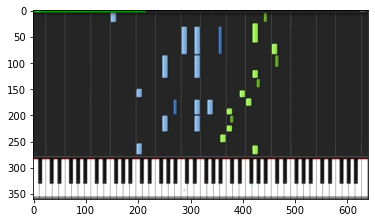

In [14]:
#sample piano image from youtube
img_notes = cv2.imread("synthesia_notes.png")

#converting to gray
gray_notes = cv2.cvtColor(img_notes, cv2.COLOR_BGR2GRAY)
img_notes_rgb = cv2.cvtColor(img_notes, cv2.COLOR_BGR2RGB)

plt.imshow(img_notes_rgb)
# plt.axis('off')
plt.show()

*y_cord[1]* is the position of the top of the keyboard. We calculated this using **half** the original image, so we need to add this back in.

# I added it back paps =3

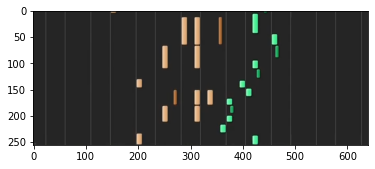

In [15]:
#Cropped
top_keys_index = y_cord[1] + img_notes.shape[0]//2
crop_img_notes = img_notes[20:int(top_keys_index)-10] #Crop the top 20 pixels and bottom 10

plt.imshow(crop_img_notes)

Identify notes.

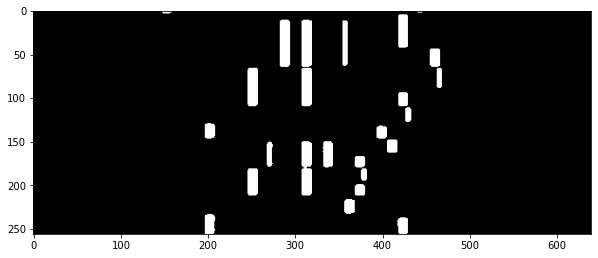

In [16]:
crop_img_notes_gray = cv2.cvtColor(crop_img_notes, cv2.COLOR_BGR2GRAY)
k = 3
blurred = cv2.GaussianBlur(crop_img_notes_gray, (k,k), 0)

#Using standard threshold to create contrast between white/black keys
_, th_notes = cv2.threshold(blurred, 65, 65, cv2.THRESH_BINARY)

plt.figure(figsize=(10,10))
plt.imshow(th_notes, cmap = "gray")
plt.show()

In [17]:
#creating a class Note so it's just easier to access all the notes that are 'relevant' 
class Note: 
    def __init__(self, centroid_x, y_dot):
        self.centroid_x = centroid_x
        self.y_dot = y_dot

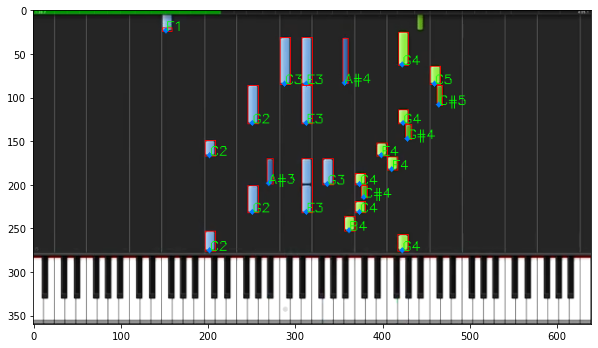

In [30]:
#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 1
output = cv2.connectedComponentsWithStats(th_notes, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]

final_labels = []
note_list = [] #creating a list of all the relavent notes. 


output = img_notes_rgb.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

#For loop only used for displaying 
for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cY = cY + 20 # We cropped out the first 20 pixels
    if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
        final_labels.append(i)
        cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
        dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
        cv2.circle(output, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)
        componentMask = (labels == i).astype("uint8") * 255
        
        note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
        note_list.append(note)
        
        note_played = key_pressed(full_key_list, note.centroid_x)
        cv2.putText(output, note_played, (int(note.centroid_x), int(note.y_dot)), font, 0.5, (0,255,0), 1)

#         display_img("Output", output)
#         display_img("Connected Component", componentMask)
#         cv2.waitKey(0)

# print(final_labels)
# cv2.destroyAllWindows()
plt.figure(figsize=(10,10))
plt.imshow(output)
plt.show()

Testing video - I downloaded a copy of the same video we used to calibrate the image detection above.

In [80]:
import imutils
camera = cv2.VideoCapture('Nocturne Opus 9 No 2.mp4')

frames = camera.get(cv2.CAP_PROP_FRAME_COUNT)
fps = camera.get(cv2.CAP_PROP_FPS)
seconds_per_frame = fps/frames
counter = 0

notes_pressed = []

while True:
    
    #grabbed is a boolean than tells us if there is a valid frame
    (grabbed, frame) = camera.read()
    counter += seconds_per_frame
    if not grabbed:
        break
        
         
    frame = imutils.resize(frame,width = img.shape[1]) #resize or else it won't work
    #print(frame.shape)
    
    crop_frame = frame[20:int(top_keys_index)-10] #Crop the top 20 pixels and bottom 10
    
    # threshold the cropped and grayed image
    crop_frame_gray = cv2.cvtColor(crop_frame, cv2.COLOR_BGR2GRAY)
    k = 3
    blurred = cv2.GaussianBlur(crop_frame_gray, (k,k), 0)
    _, th_crop_frame = cv2.threshold(blurred, 65, 65, cv2.THRESH_BINARY)

    #####################################################################################
    ####### using connected component detection algorithm to separate all the notes
    connectivity = 1
    output = cv2.connectedComponentsWithStats(th_crop_frame, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]

    font = cv2.FONT_HERSHEY_SIMPLEX
    output = frame.copy()

    #For loop only used for displaying 
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        cY = cY + 20 # We cropped out the first 20 pixels
        if (25 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
            cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
            dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
            cv2.circle(output, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)
            cv2.circle(output, (int(cX), int(cY-dist_to_edge)), 1, (0,122,255), 3)
            note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
            note_played = key_pressed(full_key_list, note.centroid_x)
            notes_pressed.append([counter, note_played])
            cv2.putText(output, note_played, (int(note.centroid_x), int(note.y_dot)), font, 0.5, (0,255,0), 1)

    cv2.line(output, (0,int(y_cord[0]+50)),(600,int(y_cord[0]+50)),(255,0,0), 2)
    #Show the frame + drawn rectangle
    cv2.imshow("Video", output)

    #Can break early by pressing "q"
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
    
camera.release()
cv2.destroyAllWindows()

In [89]:
#printing seconds associated with notes... :s
for i in range(18000,18500):
    print(notes_pressed[i])


[4.586670196571679, 'G4']
[4.586670196571679, 'B2']
[4.5906413395990135, 'C4']
[4.5906413395990135, 'A2']
[4.5906413395990135, 'C3']
[4.5906413395990135, 'D#3']
[4.5906413395990135, 'G3']
[4.5906413395990135, 'D#4']
[4.5906413395990135, 'G2']
[4.5906413395990135, 'D#3']
[4.5906413395990135, 'C2']
[4.5906413395990135, 'D3']
[4.5906413395990135, 'F#3']
[4.5906413395990135, 'D4']
[4.5906413395990135, 'G2']
[4.5906413395990135, 'G4']
[4.5906413395990135, 'B2']
[4.594612482626348, 'C4']
[4.594612482626348, 'A2']
[4.594612482626348, 'C3']
[4.594612482626348, 'D#3']
[4.594612482626348, 'G3']
[4.594612482626348, 'D#4']
[4.594612482626348, 'G2']
[4.594612482626348, 'D#3']
[4.594612482626348, 'C2']
[4.594612482626348, 'D3']
[4.594612482626348, 'F#3']
[4.594612482626348, 'D4']
[4.594612482626348, 'G2']
[4.594612482626348, 'F3']
[4.594612482626348, 'G4']
[4.594612482626348, 'B2']
[4.598583625653683, 'C4']
[4.598583625653683, 'A2']
[4.598583625653683, 'C3']
[4.598583625653683, 'D#3']
[4.59858362565